In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import torch
from torch import Tensor
from torch.utils.data import DataLoader, Subset
from torch import nn
import torch.optim
from torch.optim import SGD
import torch.nn.functional as F

import sys
sys.path.append('../code')

import toy_data as toy
from vae import VAE, loss_function, cVAE, fit
import vae as v

from tqdm_utils import TqdmProgressCallback
from tqdm import tqdm_notebook as tqdm

from functools import partial

from IPython.core.debugger import set_trace
from IPython.display import display, Markdown, Latex

# from notebook_utils import *
import notebook_utils as nu

import GPyOpt

# Some parameters:
N = 3600000  # number of observations
batch_size = 128
d = 64  # image edge length
D = d**2
img_shape = (d, d)
latent_dim = 4
print(f"{N} points with {D} dimensions.")

from functools import partial
plot_sample_grid = partial(nu.plot_sample_grid, img_shape=img_shape)

# setting up torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f'Pytorch: Train with {device}')
device = torch.device(device)

# parameters:
eps = np.random.rand(3)
bone_lengths = d//6 * (eps/2+1-1/3)
print("Bone lengths:", bone_lengths)
key_marker_width = 1.5 * d/32
labels = 1/2*np.pi*(np.random.rand(N, 3)-0.5)
labels[:, 0] = labels[:, 0] * 4

# generate training data
h = toy.HierarchyImages(angles=labels, bone_lengths=bone_lengths,
                        key_marker_width=key_marker_width,
                        img_shape=img_shape)

# data loader for easy batching
data_loader = DataLoader(h, batch_size=batch_size, shuffle=True, num_workers=4,
                         drop_last=True)

# generate validation data
labels_val = 1/2*np.pi*(np.random.rand(N//10, 3)-0.5)
labels_val[:, 0] = labels_val[:, 0] * 4

h_val = toy.HierarchyImages(angles=labels_val, bone_lengths=bone_lengths,
                            key_marker_width=key_marker_width,
                            img_shape=img_shape)

val_loader = DataLoader(h_val, batch_size=batch_size, shuffle=False, num_workers=4,
                        drop_last=True)

# dataloader dictionary with reduced validation set size
dataloader = {'train': data_loader,
              'val': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=1024)),
                               drop_last=True, batch_size=batch_size)}
dataloader = {'train': data_loader,
              'val': val_loader}

# dataloader with size comparable of PCA's datasize limit
subsets = {k: Subset(h, np.random.choice(range(len(v)), size=5000)) for k, v in zip(['train', 'val'], [h, h_val])}
reduced_dataloader = {k: DataLoader(subsets[k], batch_size=batch_size, drop_last=True) for k in subsets}

# # generate, encode, and decode new image for validation
# idx = np.random.randint(0, len(h_val))
# test_img = h_val[idx]['image']
# test_angles = h_val[idx]['angles']
# # h.plot_image(np.random.randint(0, len(labels)))

Using TensorFlow backend.


3600000 points with 4096 dimensions.
Pytorch: Train with cuda
Bone lengths: [9.69364224 6.71491432 6.69275345]


In [2]:
# d = [np.load('bayesoptXY.npz'), np.load('bayesoptXY_2.npz')]
# X = np.concatenate((d[0]['X'], d[1]['X']), axis=0)
# Y = np.concatenate((d[0]['Y'], d[1]['Y']), axis=0)
d = np.load('bayesoptXY_3.npz')
X, Y = d['X'], d['Y']

In [3]:
def f(inp):
    beta = inp[0, 0]
    latent_dim = inp[0, 1]
    display(Markdown(f'### beta: {beta:.2f}, latent: {int(latent_dim)}'))
    try:
        cvae = cVAE(input_dim=D, latent_dim=int(latent_dim),
                    pose_dim=3, likelihood='bernoulli',
                    hidden=1500).to(device)
        val_loss = fit(cvae, dataloader, epochs=1, device=device, 
                       weight_fn=f'beta{beta:.2f}dim{latent_dim}.pt',
                       # weight_fn=None,
                  conditional=True, plotter=plotter, beta=beta)
    except RuntimeError:
        print('Runtime Error')
        return [[np.nan]]
    # del cvae
    # torch.cuda.empty_cache()
    return val_loss

plotter = nu.VisdomLinePlotter(env_name='main')
bounds = [
          {'name': 'var_1', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (2, 40)}
]
opt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, num_cores=4, model_type='GP',
                                          initial_design_numdata=2, initial_design_type='latin',
                                          verbosity_model=True, exact_feval=False,
                                          X=X, Y=Y)

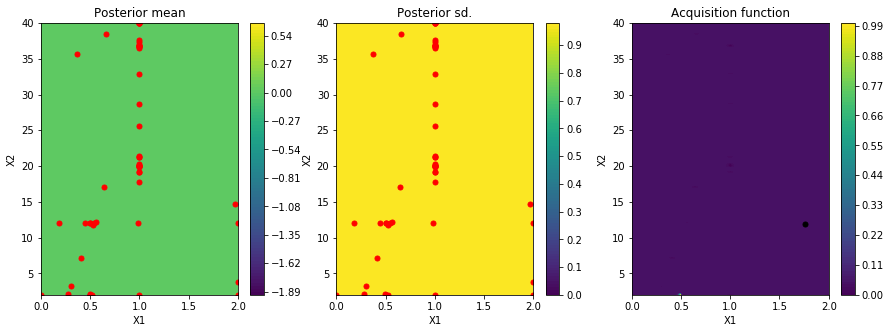

### beta: 0.91, latent: 17

Loss stopped decreasing.

train loss: 3.06E-01
val loss: 8.61E+03


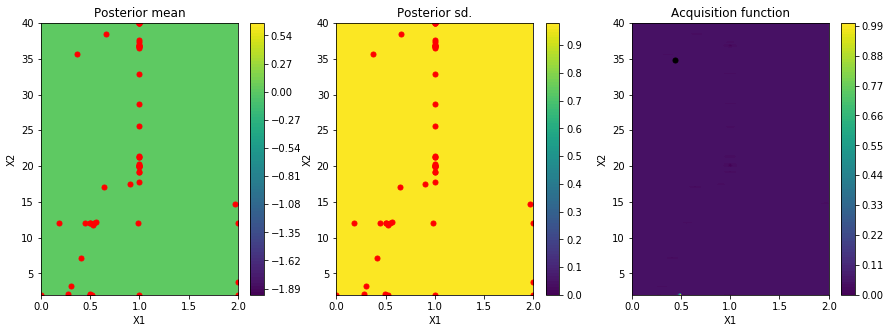

### beta: 1.81, latent: 10

Loss stopped decreasing.

train loss: 3.06E-01
val loss: 8.61E+03


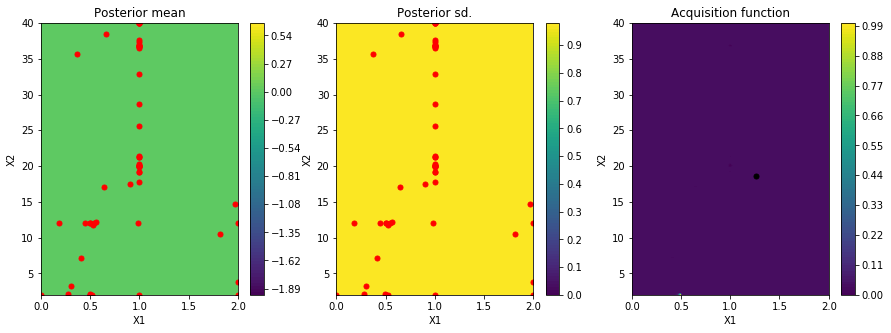

### beta: 1.43, latent: 23

Loss stopped decreasing.

train loss: 3.07E-01
val loss: 8.63E+03


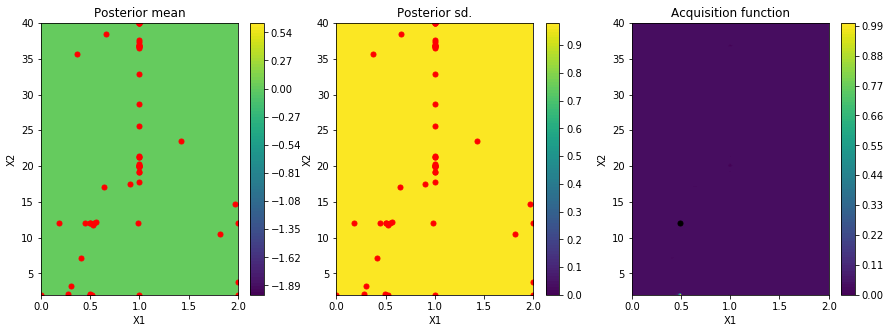

### beta: 0.13, latent: 36

Loss stopped decreasing.

train loss: 3.04E-01
val loss: 8.56E+03


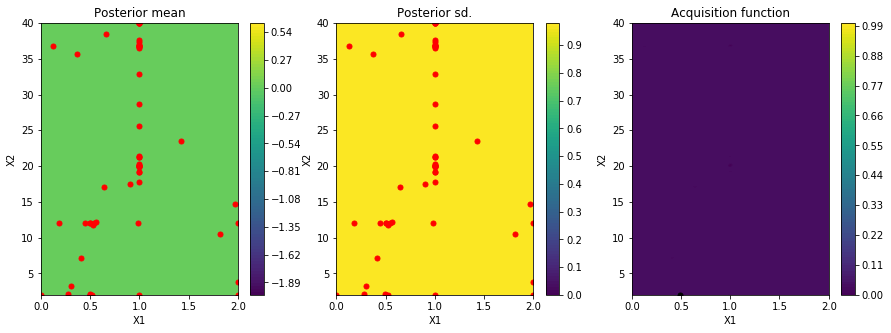

### beta: 1.82, latent: 7

Loss stopped decreasing.

train loss: 3.06E-01
val loss: 8.60E+03


In [5]:
for i in range(5):
    opt.plot_acquisition()
    opt.run_optimization(max_iter=1)
    np.savez('bayesoptXY_3.npz', X=opt.X, Y=opt.Y)